In [36]:
import numpy as np
import graph_tool.all as gt
from rich import print
import random
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd
from simulation_with_time_window import simulate_SIS, make_node_feature_df, VaccinationStrategy
from get_vertices_to_vaccinate import vertices_to_vaccinate_per_strategy


Hello from cn-final-project!

[20. 10. 28. ...  1. -1. -1.]

fraction vaccinated at start: 0.09997970641953595

fraction infected at start: 0.09997970641953595

100%|██████████| 1233/1233 [03:20<00:00,  6.15it/s, Infected fraction=0.0116]


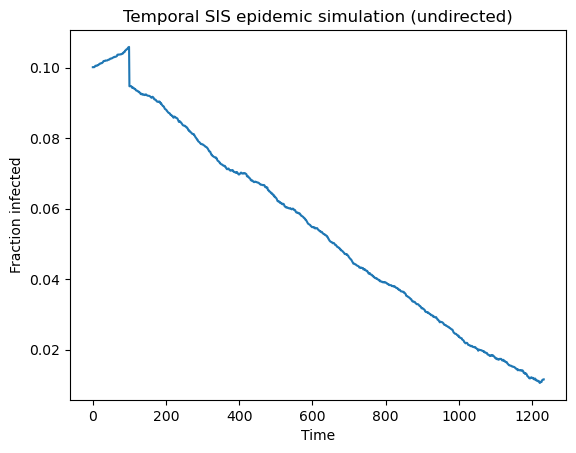

In [ ]:
random.seed(42)
print("Hello from cn-final-project!")
g = gt.collection.ns["escorts"]

sim, g = sorted_vertices = simulate_SIS(
	g, 
	max_steps=None, 
	start=1000,
	vaccine_strategy=VaccinationStrategy(1)
)

plt.plot(sim)
plt.xlabel("Time")
plt.ylabel("Fraction infected")
plt.title("Temporal SIS epidemic simulation (undirected)")
plt.savefig("plots/temporal_sis_simulation_with_time_window.png")
plt.show()

Hello from cn-final-project!

[20. 10. 28. ...  1. -1. -1.]

fraction vaccinated at start: 0.0

fraction infected at start: 0.09997970641953595

100%|██████████| 1233/1233 [03:22<00:00,  6.08it/s, Infected fraction=0.125]


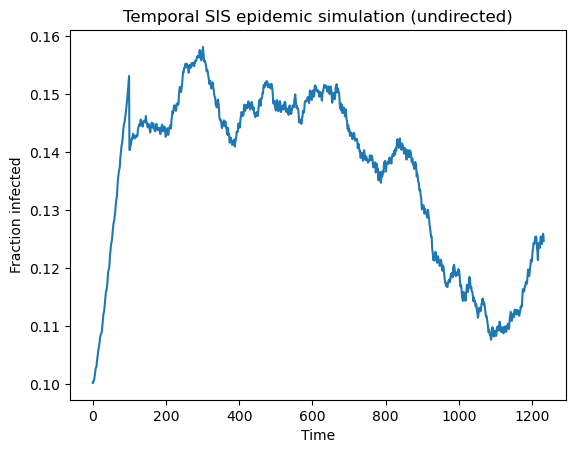

In [ ]:
random.seed(42)
print("Hello from cn-final-project!")
g = gt.collection.ns["escorts"]

sim, g = sorted_vertices = simulate_SIS(
	g, 
	max_steps=None, 
	start=1000,
	vaccine_strategy=None
)

plt.plot(sim)
plt.xlabel("Time")
plt.ylabel("Fraction infected")
plt.title("Temporal SIS epidemic simulation (undirected)")
plt.savefig("plots/temporal_sis_simulation_with_time_window.png")
plt.show()

In [8]:
df = make_node_feature_df(g)
print(df)

Computing centrality metrics...

Computed degree

Computed leverage

Computed betweenness

node  degree  leverage  betweenness  cumulative_infected
0          0      49  0.709559     0.002755                    2
1          1      24 -0.244821     0.001299                    6
2          2      39  0.407448     0.001819                    5
3          3       1 -0.920000     0.000000                    0
4          4       1 -0.960000     0.000000                    0
...      ...     ...       ...          ...                  ...
16725  16725       1 -0.333333     0.000000                    0
16726  16726       1  0.000000     0.000000                    0
16727  16727       1  0.000000     0.000000                    0
16728  16728       1  0.000000     0.000000                    0
16729  16729       1  0.000000     0.000000                    0

[16730 rows x 5 columns]

<Axes: xlabel='betweenness', ylabel='cumulative_infected'>

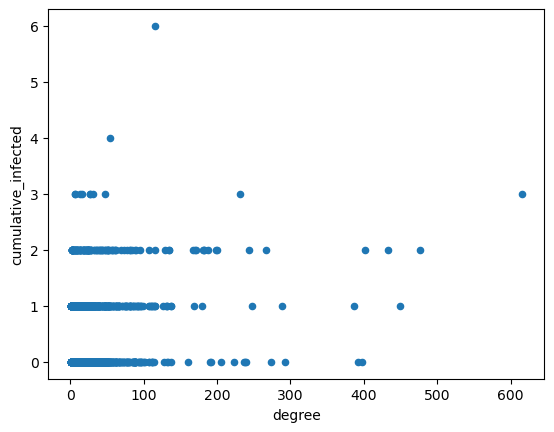

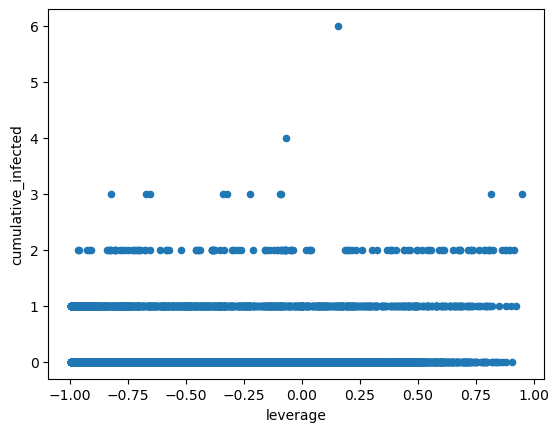

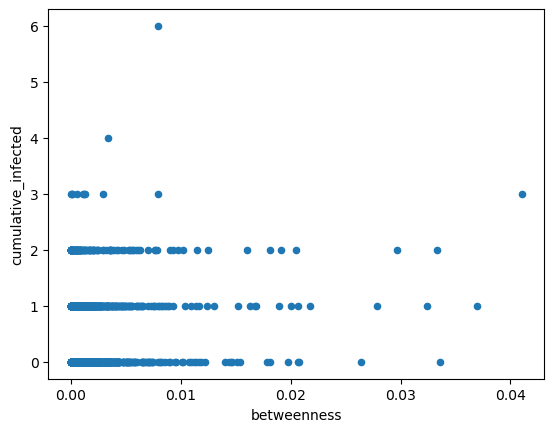

In [5]:
df.plot.scatter(x="degree", y="cumulative_infected")
df.plot.scatter(x="leverage", y="cumulative_infected")
df.plot.scatter(x="betweenness", y="cumulative_infected")


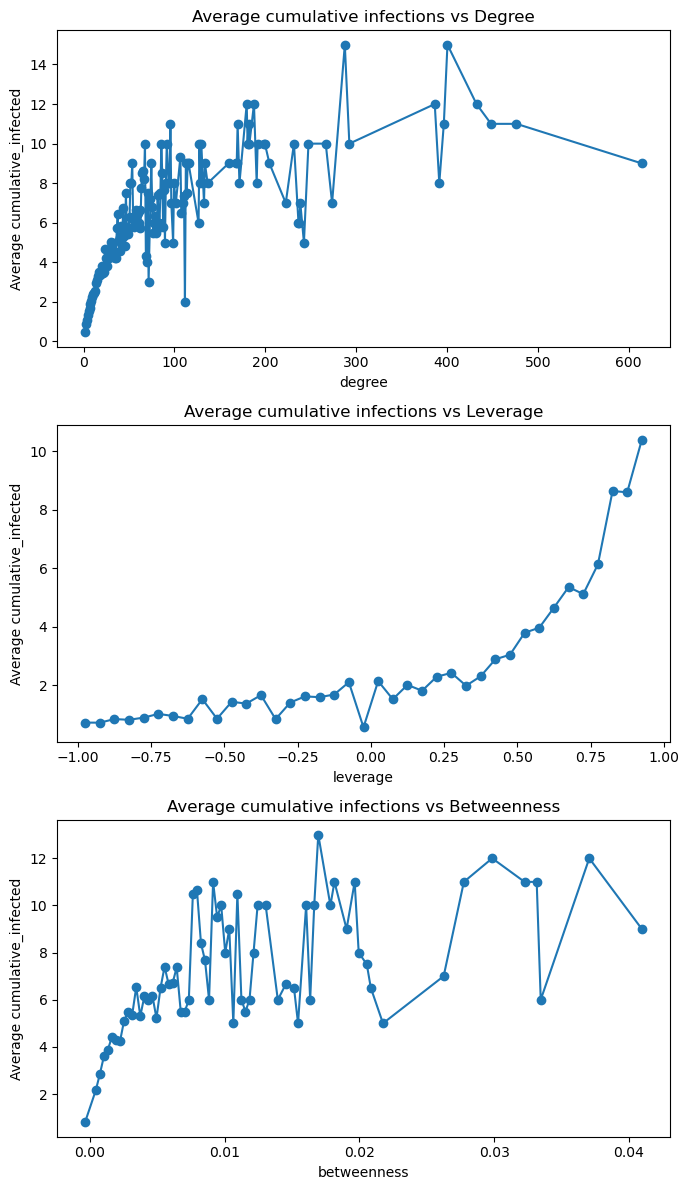

In [ ]:
def binned_mean_plot(df, x_col, y_col="cumulative_infected", bin_size=None, bins=None, ax=None, title=None):
	"""
	Used to plot cumulative_infected vs node property for 1 run

	Plot the mean of y_col within bins of x_col.
	- If bins is given, it overrides bin_size.
	- If neither is given and x_col is integer-like, groups by exact value.
	- Returns the aggregated dataframe with columns: ['bin_left','bin_right','center','mean','count'].
	"""
	data = df[[x_col, y_col]].dropna()

	if bins is None and bin_size is None:
		# If no binning specified, group by exact x (useful for integer degrees)
		grp = data.groupby(x_col)[y_col].agg(['mean','count']).reset_index()
		centers = grp[x_col].to_numpy()
		mean_vals = grp['mean'].to_numpy()
		counts = grp['count'].to_numpy()
		agg = pd.DataFrame({
			'bin_left': centers, 'bin_right': centers, 'center': centers,
			'mean': mean_vals, 'count': counts
		})
	else:
		if bins is None:
			xmin, xmax = data[x_col].min(), data[x_col].max()
			# nice edges covering [xmin, xmax]
			start = np.floor(xmin / bin_size) * bin_size
			stop  = np.ceil(xmax / bin_size) * bin_size + bin_size
			bins = np.arange(start, stop, bin_size)

		cut = pd.cut(data[x_col], bins=bins, include_lowest=True)
		grp = data.groupby(cut, observed=True)[y_col].agg(['mean','count'])
		# bin centers
		centers = np.array([iv.left + (iv.right - iv.left)/2 for iv in grp.index])
		mean_vals = grp['mean'].to_numpy()
		counts = grp['count'].to_numpy()
		agg = pd.DataFrame({
			'bin_left': [iv.left for iv in grp.index],
			'bin_right': [iv.right for iv in grp.index],
			'center': centers,
			'mean': mean_vals,
			'count': counts
		}).dropna(subset=['mean'])

	if ax is None:
		ax = plt.gca()
	ax.plot(agg['center'], agg['mean'], marker='o', linestyle='-')
	ax.set_xlabel(x_col)
	ax.set_ylabel(f'Average {y_col}')
	if title:
		ax.set_title(title)

	return agg

# ---------- Usage ----------
# 1) Degree (exact-by-degree or with bin_size=1)
fig, axes = plt.subplots(3, 1, figsize=(7, 12))

_ = binned_mean_plot(df, 'degree', y_col='cumulative_infected',
					 bin_size=1, ax=axes[0],
					 title='Average cumulative infections vs Degree')

# 2) Leverage (choose a bin size, e.g. 0.05)
_ = binned_mean_plot(df, 'leverage', y_col='cumulative_infected',
					 bin_size=0.05, ax=axes[1],
					 title='Average cumulative infections vs Leverage')

# 3) Betweenness (often skewed; pick a sensible bin size, or define custom bins)
# Example with custom quantile bins:
q = np.linspace(0, 1, 21)
# bw_edges = np.unique(np.quantile(df['betweenness'].dropna(), q))
_ = binned_mean_plot(df, 'betweenness', y_col='cumulative_infected',
					 bin_size=0.0003, ax=axes[2],
					 title='Average cumulative infections vs Betweenness')

plt.tight_layout()
plt.show()


In [ ]:
def plot_cumulative_infected_vs_properties(
	n_runs, max_steps, start, properties,
	bin_size,                 # float or dict {prop: float}
	use_ci=False,             # <-- default: ± std (not CI)
	min_bins=2,
	max_bins=1_000_000
):
	"""
	Run n_runs SIS simulations, collect per-run node features, and plot
	cumulative_infected vs each property using FIXED-WIDTH bins.

	Plots mean with error bars (± std by default, or 95% CI if use_ci=True),
	and connects all successive points with a line.
	"""
	assert len(properties) == 3, "Please pass exactly three property names."
	g0 = gt.collection.ns["escorts"]

	# ---- Collect per-run node features ----
	frames = []
	for r in range(n_runs):
		g = g0.copy()
		_, g_out = simulate_SIS(g, max_steps=max_steps, start=start)
		print(f"simulation run {r} done")
		dfr = make_node_feature_df(g_out)
		print(f"make node features run {r} done")
		dfr["run"] = r
		frames.append(dfr)

	df_all = pd.concat(frames, ignore_index=True)

	required = {"cumulative_infected", *properties}
	missing = required - set(df_all.columns)
	if missing:
		raise ValueError(f"Missing columns in node features: {missing}")

	# normalize bin_size input
	if isinstance(bin_size, (int, float)):
		bin_size_map = {p: float(bin_size) for p in properties}
	elif isinstance(bin_size, dict):
		bin_size_map = {p: float(bin_size[p]) for p in properties}
	else:
		raise TypeError("bin_size must be a float or dict {prop: float}")

	results = {}
	max_bins = int(max_bins)

	for prop in properties:
		w = bin_size_map[prop]
		if w <= 0:
			raise ValueError(f"bin_size for {prop} must be > 0")

		# global min/max across all runs for this property
		x_all = df_all[prop].to_numpy()
		x_all = x_all[np.isfinite(x_all)]
		if x_all.size == 0:
			raise ValueError(f"No finite values for property '{prop}'.")
		x_min, x_max = np.min(x_all), np.max(x_all)
		if x_max == x_min:  # constant feature → create a tiny span
			x_max = x_min + w

		# fixed-width edges; include max
		edges = np.arange(x_min, x_max + w, w, dtype=float)
		if edges.size < 2:
			edges = np.array([x_min, x_min + w], dtype=float)

		n_bins = len(edges) - 1
		if n_bins < min_bins:
			edges = np.linspace(x_min, x_min + min_bins * w, min_bins + 1)
			n_bins = min_bins
		if n_bins > max_bins:
			raise ValueError(
				f"Too many bins for '{prop}' ({n_bins}). "
				f"Increase bin_size or raise max_bins."
			)

		# nudge last edge so np.digitize includes max
		eps = np.finfo(float).eps * max(1.0, abs(edges[-1]))
		edges[-1] += eps

		# per-run bin means to avoid run-size bias
		per_run_bin_means = np.full((n_runs, n_bins), np.nan)
		for r in range(n_runs):
			dfr = df_all[df_all["run"] == r]
			xv = dfr[prop].to_numpy()
			yv = dfr["cumulative_infected"].to_numpy()

			ids = np.digitize(xv, edges, right=False) - 1
			ids = np.clip(ids, 0, n_bins - 1)

			for b in range(n_bins):
				vals = yv[ids == b]
				if vals.size:
					per_run_bin_means[r, b] = np.nanmean(vals)

		# aggregate across runs
		centers = 0.5 * (edges[:-1] + edges[1:])
		mean = np.nanmean(per_run_bin_means, axis=0)

		# effective sample count per bin (how many runs contributed)
		n_eff = np.sum(~np.isnan(per_run_bin_means), axis=0)

		# std: 0 when only one run contributed (avoid NaN from ddof=1)
		std = np.empty_like(mean)
		std[:] = np.nan
		multi_mask = n_eff > 1
		single_mask = n_eff == 1
		if np.any(multi_mask):
			std[multi_mask] = np.nanstd(per_run_bin_means[:, multi_mask], axis=0, ddof=1)
		if np.any(single_mask):
			std[single_mask] = 0.0

		if use_ci:
			sem = np.divide(std, np.sqrt(np.clip(n_eff, 1, None)), out=np.zeros_like(std), where=n_eff>0)
			yerr = 1.96 * sem
			err_label = "95% CI over runs"
		else:
			yerr = std
			err_label = "±1 std over runs"

		# keep only finite points so all remaining dots connect
		ok = np.isfinite(centers) & np.isfinite(mean) & np.isfinite(yerr)
		x_plot = centers[ok]
		y_plot = mean[ok]
		yerr_plot = yerr[ok]

		# plot: dots with error bars and connecting line
		plt.figure()
		plt.errorbar(
			x_plot, y_plot, yerr=yerr_plot,
			fmt="o-",            # dots + connected line
			capsize=3,           # errorbar caps
			elinewidth=1,
			label=f"Mean over {n_runs} runs ({err_label})"
		)
		plt.xlabel(prop)
		plt.ylabel("Cumulative infected")
		plt.title(f"Cumulative infected vs {prop} (bin size = {w})")
		plt.legend()

		results[prop] = {
			"bin_edges": edges,
			"bin_centers": centers,
			"mean": mean,
			"yerr": yerr,
			"per_run_bin_means": per_run_bin_means,
		}

	return results

[20. 10. 28. ...  1. -1. -1.]

fraction infected at start: 0.08333333333333333

100%|██████████| 2/2 [00:00<00:00,  6.78it/s, Infected fraction=0.167]


simulation run 0 done

Computing centrality metrics...

Computed degree

Computed leverage

Computed betweenness

make node features run 0 done

/tmp/ipykernel_4989/3360580174.py:97: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(per_run_bin_means, axis=0)


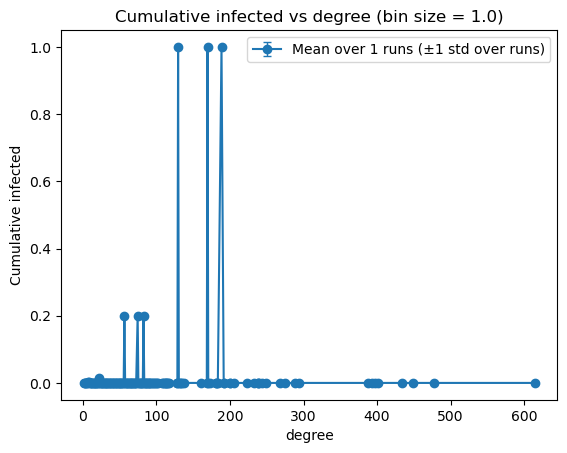

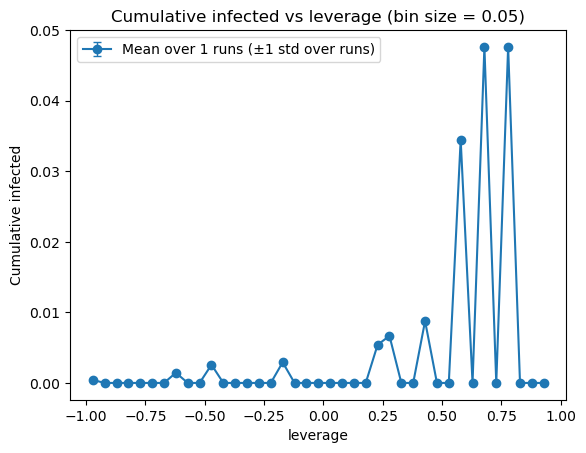

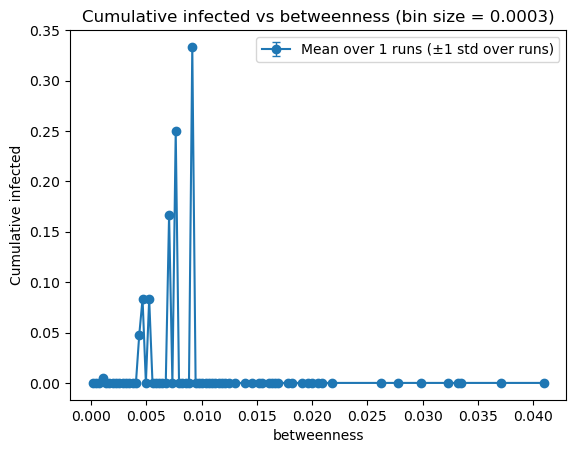

In [ ]:
bin_sizes = {
	"degree": 1.0,
	"leverage": 0.05,
	"betweenness": 0.0003,
}
res = plot_cumulative_infected_vs_properties(
	n_runs=1, max_steps=1, start=1000,
	properties=["degree", "leverage", "betweenness"],
	bin_size=bin_sizes,
	use_ci=False
)


In [18]:
vs = VaccinationStrategy(1)
vs = None

In [ ]:
# Apply vaccination strategy
strats = {
	'deg': False,
	'str': False,
	'bet': False,
	'lev': False,
	'_': False
}

match vs:
	case VaccinationStrategy.DEGREE:
		strats['deg'] = True
	case VaccinationStrategy.STRENGTH:
		strats['str'] = True
	case VaccinationStrategy.BETWEENNESS:
		strats['bet'] = True
	case VaccinationStrategy.LEVERAGE:
		strats['lev'] = True
	case _:
		strats['_'] = True

strats

{'deg': False, 'str': False, 'bet': False, 'lev': False, '_': True}

In [ ]:
random.seed(420)
print("Hello from cn-final-project!")
g = gt.collection.ns["escorts"]

sorted_vertices = simulate_SIS(
	g, 
	max_steps=200, 
	start=1000,
	vaccine_strategy=VaccinationStrategy(1)
)

Hello from cn-final-project!

KeyboardInterrupt: 

TabError: inconsistent use of tabs and spaces in indentation (<string>, line 19)

In [24]:
def vertices_to_vaccinate_per_strategy(
	g: gt.Graph = gt.collection.ns["escorts"],
	start: int = 1000,
	vaccine_fraction: float = 0.1,
	max_steps: int | None = None
) -> dict[VaccinationStrategy, list[tuple[gt.Vertex, float]]]:
	
	""" 
	Note: Still have to add time respecting betweenness and WTS
	
	Returns a dict where the keys are vaccination strategies and the items are a list of
	tuples containing the vertices to vaccinate and the relevant vertex metric for the strategy.
	"""
	
	def make_list_to_vaccinate(
		num_to_vaccinate: int,
		metric_values: dict[gt.Vertex, float]
	) -> list[tuple[gt.Vertex, float]]:
			
		"""
		Returns list of tuples containing vertices to vaccinate and their metric value.
		The list is high to low ordered by metric value  
		"""
		ranked_active = sorted(
			((v, metric_values[v]) for v in active_vertices),
			key=lambda item: item[1],
			reverse=True
		)
		to_vaccinate = ranked_active[:num_to_vaccinate]
	
		return to_vaccinate

	# make set of active edges given start
	edge_time = g.edge_properties["time"]
	max_time = int(max(edge_time[e] for e in g.edges()))
	if max_steps is not None:
		max_time = min(max_time, max_steps + start)

	active_vertices = set()
	for e in g.edges():
		t = edge_time[e]
		if start <= t <= max_time:
			active_vertices.add(e.source())
			active_vertices.add(e.target())
			
	# number of vertices to vaccinate
	num_to_vaccinate = int(len(active_vertices) * vaccine_fraction)

	# this will become the output dict
	d = {}

	# add DEGREE vertices to vaccinate
	degree = g.degree_property_map("total")
	metric_values = {v: degree[v] for v in g.vertices()}
	d[VaccinationStrategy(1)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)

	# add LEVERAGE vertices to vaccinate
    leverage = g.new_vertex_property("float")
    for v in g.vertices():
        deg = v.out_degree() + v.in_degree()
        if deg > 1:
            degree_sum = sum(
                ((deg - (u.out_degree() + u.in_degree())) / (deg + (u.out_degree() + u.in_degree())))
                for u in v.all_neighbors()
            )
            leverage[v] = degree_sum / deg
        else:
            leverage[v] = 0.0

	metric_values = {v: leverage[v] for v in g.vertices()}
	d[VaccinationStrategy(2)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)
		
	# add STRENGTH vertices to vaccinate
	strength = g.new_vertex_property("float")
    ratings = g.edge_properties["rating"]
    for e in g.edges():
        src, trt = e.source(), e.target()
        strength[src] += ratings[e]
        strength[trt] += ratings[e]
        
    metric_values = {}
	metric_values = {v: leverage[v] for v in g.vertices()}
	d[VaccinationStrategy(3)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)

	# add BETWEENNESS vertives to vaccinate
	betweenness = gt.betweenness(g)[0]
	metric_values = {}
	metric_values = {v: betweenness[v] for v in g.vertices()}
	d[VaccinationStrategy(4)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)

	return d

IndentationError: unindent does not match any outer indentation level (<string>, line 58)

In [ ]:
def vertices_to_vaccinate_per_strategy(
    g: gt.Graph = gt.collection.ns["escorts"],
    start: int = 1000,
    vaccine_fraction: float = 0.1,
    max_steps: int | None = None
) -> dict[VaccinationStrategy, list[tuple[gt.Vertex, float]]]:
    
    """ 
    Note: Still have to add time respecting betweenness and WTS
    
    Returns a dict where the keys are vaccination strategies and the items are a list of
    tuples containing the vertices to vaccinate and the relevant vertex metric for the strategy.
    """
    
    def make_list_to_vaccinate(
        num_to_vaccinate: int,
        metric_values: dict[gt.Vertex, float]
    ) -> list[tuple[gt.Vertex, float]]:
        """
        Returns list of tuples containing vertices to vaccinate and their metric value.
        The list is high to low ordered by metric value  
        """
        ranked_active = sorted(
            ((v, metric_values[v]) for v in active_vertices),
            key=lambda item: item[1],
            reverse=True
        )
        to_vaccinate = ranked_active[:num_to_vaccinate]
        return to_vaccinate

    # make set of active edges given start
    edge_time = g.edge_properties["time"]
    max_time = int(max(edge_time[e] for e in g.edges()))
    if max_steps is not None:
        max_time = min(max_time, max_steps + start)

    active_vertices = set()
    for e in g.edges():
        t = edge_time[e]
        if start <= t <= max_time:
            active_vertices.add(e.source())
            active_vertices.add(e.target())
            
    # number of vertices to vaccinate
    num_to_vaccinate = int(len(active_vertices) * vaccine_fraction)

    # this will become the output dict
    d = {}

    # add DEGREE vertices to vaccinate
    degree = g.degree_property_map("total")
    metric_values = {v: degree[v] for v in g.vertices()}
    d[VaccinationStrategy(1)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)
    print("degree compuation done")

    # add LEVERAGE vertices to vaccinate
    leverage = g.new_vertex_property("float")
    for v in g.vertices():
        deg = v.out_degree() + v.in_degree()
        if deg > 1:
            degree_sum = sum(
                ((deg - (u.out_degree() + u.in_degree())) / (deg + (u.out_degree() + u.in_degree())))
                for u in v.all_neighbors()
            )
            leverage[v] = degree_sum / deg
        else:
            leverage[v] = 0.0

    metric_values = {v: leverage[v] for v in g.vertices()}
    d[VaccinationStrategy(2)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)
    print("leverage compuation done")
        
    # add STRENGTH vertices to vaccinate
    strength = g.new_vertex_property("float")
    ratings = g.edge_properties["rating"]
    for e in g.edges():
        src, trt = e.source(), e.target()
        strength[src] += ratings[e]
        strength[trt] += ratings[e]

    metric_values = {v: strength[v] for v in g.vertices()}
    d[VaccinationStrategy(3)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)
    print("strength compuation done")

    # add BETWEENNESS vertices to vaccinate
    betweenness = gt.betweenness(g)[0]
    metric_values = {v: betweenness[v] for v in g.vertices()}
    d[VaccinationStrategy(4)] = make_list_to_vaccinate(num_to_vaccinate, metric_values)
    print("betweenness compuation done")

    return d


In [ ]:
d = vertices_to_vaccinate_per_strategy(
    g = gt.collection.ns["escorts"],
    start = 1000,
    vaccine_fraction = 0.1,
    max_steps = None
)

degree compuation done

leverage compuation done

strength compuation done

betweenness compuation done

In [ ]:
for i in range(1, 5):
    print(len(d[VaccinationStrategy(i)]))

0.09997970641953595

0.09997970641953595

0.09997970641953595

0.09997970641953595